In [1]:
#@title
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#@title
datasets = {'ml100k':'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
            'ml20m':'http://files.grouplens.org/datasets/movielens/ml-20m.zip',
            'mllatestsmall':'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip',
            'ml10m':'http://files.grouplens.org/datasets/movielens/ml-10m.zip',
            'ml1m':'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
            }

In [3]:
print('Available datasets: ', [key for key in datasets])
dt = input('Dataset name = ')
print('You selected {}'.format(dt))

Available datasets:  ['ml100k', 'ml20m', 'mllatestsmall', 'ml10m', 'ml1m']
Dataset name = ml100k
You selected ml100k


In [47]:
dt_name = os.path.basename(datasets[dt])

print('Downloading {}'.format(dt_name))
with urllib.request.urlopen(datasets[dt]) as response, open('./sample_data/'+dt_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
print('Download completed')

Download completed


In [48]:
with zipfile.ZipFile('./sample_data/'+dt_name, 'r') as zip_ref:
    zip_ref.extractall('./sample_data/')
dt_dir_name = os.path.splitext(dt_name)[0]

In [4]:
#Check unzipped structure
def list_files(startpath):
    print(startpath)
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
dirs = [x[0] for x in os.walk("./sample_data")]
#print(list(dirs[0]))
ml = filter(lambda dirName: dirName if ('ml' in dirName) else '', list(dirs))
dt_dir_name= list(ml)[0]
print(dt_dir_name)
#list_files('./sample_data/'+dt_dir_name +'/')

./sample_data/ml-100k


In [5]:
#100k
if dt == 'ml100k':
    dataset = pd.read_csv(dt_dir_name+"/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))

#ml1m
if dt=='ml1m':
    dataset=pd.read_csv(dt_dir_name +'/'+ 'ratings.dat', delimiter='\:\:', names=['user_id', 'item_id', 'rating', 'timestamp'])  
dataset.head()

user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

In [6]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(943, 1682)

In [7]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [8]:
#Version 1.2 (flexible + superfast negative sampling uniform)
import random
import time
import scipy

def neg_sampling(ratings_df, n_neg=1, neg_val=0, pos_val=1, percent_print=5):
    """version 1.2: 1 positive 1 neg (2 times bigger than the original dataset by default)

    Parameters:
    input rating data as pandas dataframe: userId|movieId|rating
    n_neg: include n_negative / 1 positive

    Returns:
    negative sampled set as pandas dataframe
            userId|movieId|interact (implicit)
    """
    sparse_mat = scipy.sparse.coo_matrix((ratings_df.rating, (ratings_df.user_id, ratings_df.item_id)))
    dense_mat = np.asarray(sparse_mat.todense())
    print(dense_mat.shape)

    nsamples = ratings_df[['user_id', 'item_id']]
    nsamples['rating'] = nsamples.apply(lambda row: 1, axis=1)
    length = dense_mat.shape[0]
    printpc = int(length * percent_print/100)

    nTempData = []
    i = 0
    start_time = time.time()
    stop_time = time.time()

    extra_samples = 0
    for row in dense_mat:
        if(i%printpc==0):
            stop_time = time.time()
            print("processed ... {0:0.2f}% ...{1:0.2f}secs".format(float(i)*100 / length, stop_time - start_time))
            start_time = stop_time

        n_non_0 = len(np.nonzero(row)[0])
        zero_indices = np.where(row==0)[0]
        if(n_non_0 * n_neg + extra_samples > len(zero_indices)):
            print(i, "non 0:", n_non_0,": len ",len(zero_indices))
            neg_indices = zero_indices.tolist()
            extra_samples = n_non_0 * n_neg + extra_samples - len(zero_indices)
        else:
            neg_indices = random.sample(zero_indices.tolist(), n_non_0 * n_neg + extra_samples)
            extra_samples = 0

    nTempData.extend([(uu, ii, rr) for (uu, ii, rr) in zip(np.repeat(i, len(neg_indices))
                    , neg_indices, np.repeat(neg_val, len(neg_indices)))])
    i+=1

    nsamples=nsamples.append(pd.DataFrame(nTempData, columns=["user_id","item_id", "rating"]),ignore_index=True)
    nsamples.reset_index(drop=True)
    return nsamples

In [9]:
neg_dataset = neg_sampling(dataset)


train, test = train_test_split(neg_dataset, test_size=0.2, random_state=2020)
train, val = train_test_split(train, test_size=0.2, random_state=2020)


(943, 1682)
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00secs
processed ... 0.00% ...0.00s

In [10]:
print(neg_dataset.shape, train.shape, test.shape, val.shape)

(100168, 3) (64107, 3) (20034, 3) (16027, 3)


In [11]:
print(train.shape,"\n", train.head())

(64107, 3) 
        user_id  item_id  rating
28470      420      173       1
97361      845      737       1
25497      467      248       1
72690      805     1015       1
39954      393      401       1


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.initializers import RandomUniform, he_normal,he_uniform
import math

In [13]:
model_name='model1'
seed=2020
embedding_init = RandomUniform(seed=seed)
relu_init = he_uniform(seed=seed)
embeddings_regu =l2(1e-6)

In [14]:
def create_model(dataset, n_latent_factors = 16):
    n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
    n_latent_factors = 16

    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies, n_latent_factors, 
                                          embeddings_initializer=embedding_init, 
                                          embeddings_regularizer=embeddings_regu, 
                                          embeddings_constraint="NonNeg", 
                                          name='Movie-Embedding')(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

    user_input = keras.layers.Input(shape=[1],name='User')
    user_embedding = keras.layers.Embedding(n_users, n_latent_factors, 
                                          embeddings_initializer=embedding_init, 
                                          embeddings_regularizer=embeddings_regu, 
                                          embeddings_constraint="NonNeg", 
                                          name='User-Embedding')(user_input)
    user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

    prod = keras.layers.dot([movie_vec, user_vec], axes=1,name='DotProduct')
    model = keras.Model([user_input, movie_input], prod)
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
    model.summary()
    return model

In [15]:
model = create_model(neg_dataset) 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 16)        26912       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 16)        15088       User[0][0]                       
______________________________________________________________________________________________

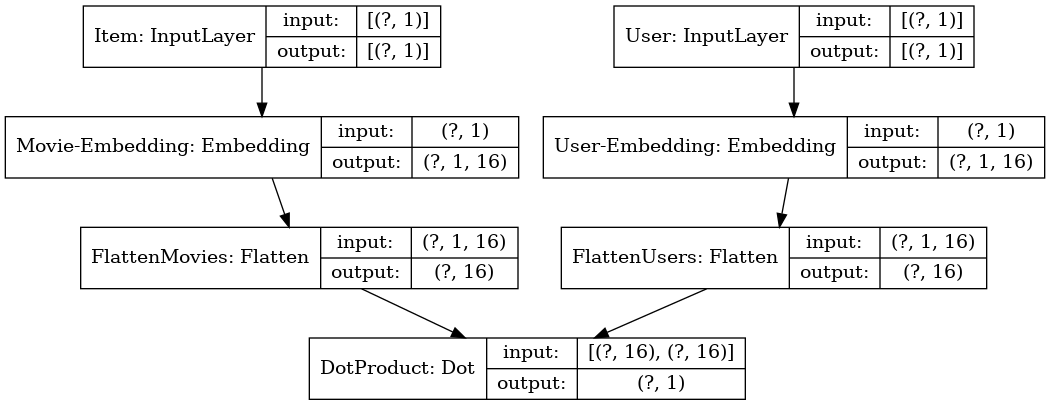

In [16]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [17]:
neg_dataset.isna().any()

user_id    False
item_id    False
rating     False
dtype: bool

In [18]:
np.isnan(neg_dataset.loc[[x for x in range(100000)], ['user_id']].to_numpy()).any()

False

In [19]:
from tensorflow.keras.utils import Sequence
import math

class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=16, shuffle=False):
        'Initialization'
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.shuffle = shuffle
        self.indices = dataframe.index
        print(len(self.indices),"\n", dataframe.isna().any())
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.floor(len(self.dataframe) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = [i for i in range(index*self.batch_size,(index+1)*self.batch_size)]
        
        # Find list of batch IDs
        list_IDs_temp = [self.indices[k] for k in idxs]

        # Generate data
        User = self.dataframe.iloc[list_IDs_temp,[0]].to_numpy().reshape(-1)
        Item = self.dataframe.iloc[list_IDs_temp,[1]].to_numpy().reshape(-1)
        rating = self.dataframe.iloc[list_IDs_temp,[2]].to_numpy().reshape(-1)
        assert(np.isnan(User).any(), User)
        assert(np.isnan(Item).any(), Item)
        assert(np.isnan(rating).any(), rating)
        #print(idxs, '\n', "u,i,", [User, Item],'\n',[rating])
        return [User, Item],[rating]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [20]:
#2  training with fit generator
train_generator = DataGenerator(train, batch_size=256, shuffle=False)
#val_generator = DataGenerator(val, batch_size=256, shuffle=False)
history = model.fit(train_generator, epochs=150, verbose=2)

64107 
 user_id    False
item_id    False
rating     False
dtype: bool
Epoch 1/150
250/250 - 2s - loss: 5.1307 - binary_accuracy: 0.0017
Epoch 2/150
250/250 - 1s - loss: 4.2697 - binary_accuracy: 0.0017
Epoch 3/150
250/250 - 1s - loss: 3.8557 - binary_accuracy: 0.0017
Epoch 4/150
250/250 - 1s - loss: 3.5691 - binary_accuracy: 0.0017
Epoch 5/150
250/250 - 1s - loss: 3.3485 - binary_accuracy: 0.0017
Epoch 6/150
250/250 - 2s - loss: 3.1688 - binary_accuracy: 0.0017
Epoch 7/150
250/250 - 1s - loss: 3.0170 - binary_accuracy: 0.0017
Epoch 8/150
250/250 - 2s - loss: 2.8855 - binary_accuracy: 0.0017
Epoch 9/150
250/250 - 2s - loss: 2.7696 - binary_accuracy: 0.0017
Epoch 10/150
250/250 - 1s - loss: 2.6658 - binary_accuracy: 0.0017
Epoch 11/150
250/250 - 1s - loss: 2.5719 - binary_accuracy: 0.0017
Epoch 12/150
250/250 - 1s - loss: 2.4862 - binary_accuracy: 0.0017
Epoch 13/150
250/250 - 1s - loss: 2.4073 - binary_accuracy: 0.0017
Epoch 14/150
250/250 - 1s - loss: 2.3342 - binary_accuracy: 0.0017


250/250 - 1s - loss: 0.3578 - binary_accuracy: 0.8080
Epoch 123/150
250/250 - 1s - loss: 0.3535 - binary_accuracy: 0.8108
Epoch 124/150
250/250 - 2s - loss: 0.3492 - binary_accuracy: 0.8136
Epoch 125/150
250/250 - 2s - loss: 0.3451 - binary_accuracy: 0.8163
Epoch 126/150
250/250 - 2s - loss: 0.3410 - binary_accuracy: 0.8192
Epoch 127/150
250/250 - 2s - loss: 0.3370 - binary_accuracy: 0.8220
Epoch 128/150
250/250 - 2s - loss: 0.3331 - binary_accuracy: 0.8249
Epoch 129/150
250/250 - 1s - loss: 0.3292 - binary_accuracy: 0.8273
Epoch 130/150
250/250 - 2s - loss: 0.3254 - binary_accuracy: 0.8298
Epoch 131/150
250/250 - 1s - loss: 0.3217 - binary_accuracy: 0.8321
Epoch 132/150
250/250 - 1s - loss: 0.3180 - binary_accuracy: 0.8349
Epoch 133/150
250/250 - 1s - loss: 0.3144 - binary_accuracy: 0.8375
Epoch 134/150
250/250 - 2s - loss: 0.3109 - binary_accuracy: 0.8400
Epoch 135/150
250/250 - 1s - loss: 0.3074 - binary_accuracy: 0.8423
Epoch 136/150
250/250 - 2s - loss: 0.3039 - binary_accuracy: 0

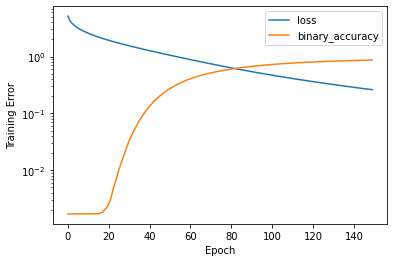

In [21]:
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['binary_accuracy']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.legend(['loss','binary_accuracy'])

In [22]:
results = model.evaluate((test.user_id, test.item_id), test.rating,
                            batch_size=16)

1253/1253 [==============================] - 1s 698us/step - loss: 0.2805 - binary_accuracy: 0.8603


In [23]:
print(results)

[0.2804707884788513, 0.8602874875068665]


In [24]:
y_hat = model.predict([test.user_id, test.item_id])
y_true = test.rating

In [25]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.3292339488160502

In [26]:
tmp_lst_u=train.user_id.unique()
tmp_lst_i=train.item_id.unique()
tmp_lst_u.sort(), tmp_lst_i.sort()
lst_user=tmp_lst_u.tolist()
lst_item=tmp_lst_i.tolist()


In [27]:
def Top_100_Unused_item(user_id):
    tmp_df_used_item=train.loc[(train['user_id']==user_id) & (train['rating']==1)]
    tmp_lst=tmp_df_used_item['item_id'].values.tolist()
    #lst_un_item= set(lst_item) - set(tmp_lst)
    lst_un_item=[x for x in lst_item if x not in tmp_lst]
    
    #random 100 items:
    tmp_no=100
    lst_100_un_item=(np.random.choice(lst_un_item,tmp_no))
    
    
    #Create DataFrame
    tmp_df=pd.DataFrame(columns=['user_id', 'item_id', 'rating', 'prediction'])
    tmp_df['item_id']=lst_100_un_item
    tmp_df['user_id']=user_id
    tmp_df['rating']=0.0

    y_hat = model.predict([tmp_df.user_id, tmp_df.item_id])
    tmp_arr=y_hat.flatten().tolist()
    tmp_df['prediction']=tmp_arr
    return tmp_df

In [28]:
Top_100_Unused_item(0)

user_id  item_id  rating  prediction
0         0      699     0.0    0.257883
1         0      491     0.0    0.466765
2         0     1415     0.0    0.131577
3         0     1190     0.0    0.082784
4         0     1236     0.0    0.148591
..      ...      ...     ...         ...
95        0      853     0.0    0.221602
96        0      350     0.0    0.234374
97        0      767     0.0    0.415250
98        0     1654     0.0    0.081086
99        0      588     0.0    0.392427

[100 rows x 4 columns]

In [29]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

0            1            2            3            4   \
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000   
mean      0.127163     0.130794     0.135646     0.131425     0.129957   
std       0.085319     0.087892     0.092102     0.087660     0.087448   
min      -0.000000    -0.000000    -0.000000    -0.000000    -0.000000   
25%       0.057574     0.059108     0.059547     0.060346     0.058243   
50%       0.109955     0.111653     0.118684     0.112632     0.113558   
75%       0.189778     0.191187     0.200725     0.193262     0.190984   
max       0.435607     0.439121     0.472790     0.443147     0.438556   

                5            6            7            8            9   \
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000   
mean      0.126800     0.127493     0.121620     0.125259     0.128148   
std       0.085292     0.085257     0.080896     0.084341     0.085694   
min      -0.000000    -0.000000    -0.000000    -0.000000    -0.000000   
25%       0.056811     0.057067     0.055322     0.055824     0.057188   
50%       0.109919     0.110269     0.106492     0.110140     0.111801   
75%       0.187318     0.186809     0.178740     0.183361     0.188130   
max       0.415125     0.430561     0.415345     0.443156     0.411269   

                10           11           12           13           14  \
count  1682.000000  1682.000000  1682.000000  1682.000000  1682.000000   
mean      0.131120     0.121595     0.130571     0.137375     0.125825   
std       0.087953     0.080501     0.088764     0.093106     0.084841   
min      -0.000000    -0.000000    -0.000000    -0.000000    -0.000000   
25%       0.060571     0.055441     0.056871     0.060655     0.053899   
50%       0.113034     0.106218     0.112128     0.118624     0.110599   
75%       0.191988     0.176509     0.191517     0.204209     0.186439   
max       0.428803     0.410979     0.434569     0.445018     0.409028   

                15  
count  1682.000000  
mean      0.135441  
std       0.091067  
min      -0.000000  
25%       0.059975  
50%       0.117579  
75%       0.198282  
max       0.471036

In [30]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

0           1           2           3           4           5   \
count  943.000000  943.000000  943.000000  943.000000  943.000000  943.000000   
mean     0.187823    0.193255    0.201269    0.193335    0.192068    0.187793   
std      0.078494    0.082119    0.083406    0.081515    0.081081    0.078260   
min      0.062865    0.071256    0.064080    0.066627    0.060416    0.067804   
25%      0.122233    0.123152    0.131115    0.125261    0.123293    0.123635   
50%      0.168053    0.177337    0.183372    0.178410    0.176037    0.173437   
75%      0.243661    0.253486    0.264943    0.251170    0.249973    0.242238   
max      0.529592    0.514458    0.521245    0.549040    0.493160    0.476545   

               6           7           8           9           10          11  \
count  943.000000  943.000000  943.000000  943.000000  943.000000  943.000000   
mean     0.188675    0.179912    0.186427    0.189667    0.194633    0.179322   
std      0.077617    0.072982    0.073995    0.078074    0.078903    0.073395   
min      0.064944    0.059239    0.063692    0.065162    0.068320    0.060024   
25%      0.124932    0.119691    0.125717    0.123219    0.127884    0.119148   
50%      0.171808    0.165246    0.171608    0.174533    0.178068    0.167624   
75%      0.242395    0.231073    0.238672    0.245139    0.250919    0.232697   
max      0.490386    0.512013    0.485087    0.499116    0.504961    0.478087   

               12          13          14          15  
count  943.000000  943.000000  943.000000  943.000000  
mean     0.194100    0.204180    0.185949    0.201677  
std      0.080494    0.084227    0.078411    0.080607  
min      0.069555    0.069396    0.059741    0.069390  
25%      0.127580    0.135038    0.120077    0.134688  
50%      0.175745    0.186662    0.170445    0.186474  
75%      0.254731    0.264805    0.243527    0.259393  
max      0.491087    0.538404    0.481192    0.504408

In [31]:
user_embedding_learnt

array([[0.16583335, 0.17485487, 0.15995544, ..., 0.20487465, 0.15653251,
        0.1737635 ],
       [0.15179966, 0.20988852, 0.15762271, ..., 0.18045789, 0.1932214 ,
        0.20826493],
       [0.19082248, 0.14982386, 0.17606355, ..., 0.18679163, 0.16372302,
        0.15833704],
       ...,
       [0.0805249 , 0.07750005, 0.07980144, ..., 0.07789763, 0.0743008 ,
        0.08284641],
       [0.17204183, 0.20669529, 0.18859877, ..., 0.21663271, 0.18645999,
        0.18061377],
       [0.27849326, 0.2551131 , 0.24871749, ..., 0.2570365 , 0.2448529 ,
        0.24766995]], dtype=float32)

In [32]:
def recommend(user_id, number_of_movies=5):
    movies = user_embedding_learnt[user_id]@movie_embedding_learnt.T
    mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
    return mids

In [33]:
recommend(user_id=1)

array([299, 293, 287, 257,  49])